# Data Visualization

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.neighbors
import sklearn.ensemble
import sklearn.cluster
import matplotlib.pyplot as plt
import ast
import gensim, logging
import xgboost
import lightgbm
import datetime

C:\Users\caioj\Anaconda3\envs\forest-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/evaluation.csv')
train_df.describe()

,retweets_count,favorites_count,followers_count,statuses_count,friends_count,verified,timestamp,TweetID
count,353969.000000,353969.000000,3.539690e+05,3.539690e+05,353969.000000,353969.000000,3.539690e+05,3.539690e+05
mean,15.831810,46.655442,2.021548e+04,4.808507e+04,1459.289003,0.030005,1.647004e+12,6.872503e+05
std,241.986723,852.044385,2.598715e+05,1.133854e+05,2502.933271,0.170602,4.846468e+09,4.175793e+05
min,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,1.301178e+12,3.000000e+00
25%,0.000000,0.000000,1.600000e+02,2.972000e+03,214.000000,0.000000,1.647068e+12,3.194490e+05
50%,1.000000,0.000000,7.260000e+02,1.250100e+04,693.000000,0.000000,1.647292e+12,6.719730e+05
75%,3.000000,1.000000,2.283000e+03,4.352200e+04,1804.000000,0.000000,1.647532e+12,1.049644e+06
max,63674.000000,122591.000000,1.441710e+07,8.183508e+06,237269.000000,1.000000,1.647727e+12,1.434456e+06


In [3]:
train_df

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049
...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,[],1647438153000,142573
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,[],1647072106000,240866
353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,[],1647607230000,1173763
353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,[],1646987195000,929182


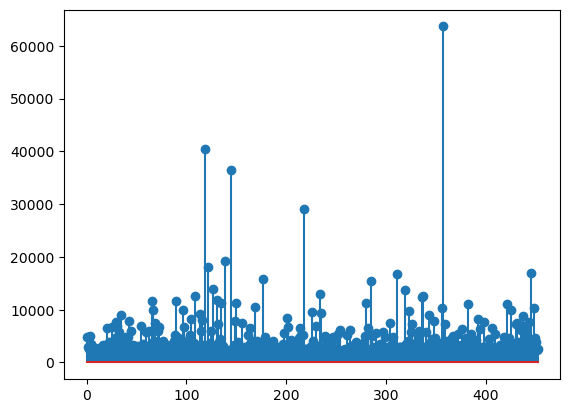

In [4]:
plt.stem(train_df[train_df['retweets_count'] > 2000]['retweets_count'])
plt.show()

In [5]:
def format_df(df: pd.DataFrame,
              type: str = 'train',
              url_len_only: bool = True,
              hashtag_len_only: bool = True,
              keep_time: bool = False,
              extra_fts: bool = False):
    final_df = df.drop(['TweetID', 'mentions', 'timestamp'], axis=1)

    final_df.urls = final_df.urls.apply(ast.literal_eval)
    final_df.hashtags = final_df.hashtags.apply(ast.literal_eval)
    if url_len_only:
        final_df.urls = final_df.urls.apply(len)
    if hashtag_len_only:
        final_df.hashtags = final_df.hashtags.apply(len)

    if keep_time:
        timestamps = df.timestamp // 1000
        timestamps = timestamps.apply(datetime.datetime.fromtimestamp).apply(datetime.datetime.timetuple)

        time_df = pd.DataFrame(timestamps.tolist(), index=df.index,
                               columns=['tm_year', 'tm_mon', 'tm_mday', 'tm_hour', 'tm_min', 'tm_sec', 'tm_wday',
                                        'tm_yday', 'tm_isdst'])
        time_df = time_df.drop(['tm_year', 'tm_mon', 'tm_mday', 'tm_isdst'], axis=1)

        final_df = pd.concat([final_df, time_df], axis=1)

    return final_df

In [6]:
new_train_df = format_df(train_df, keep_time=False, url_len_only=True, hashtag_len_only=True)

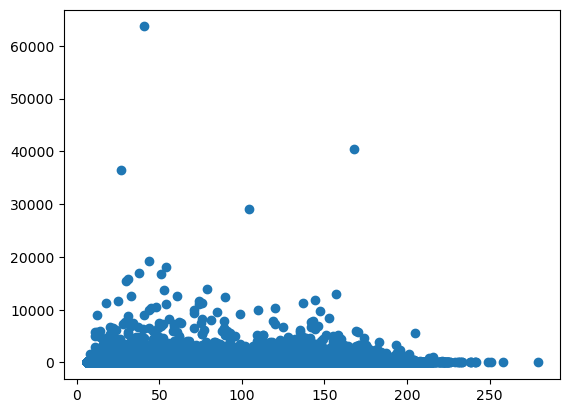

In [7]:
plt.scatter(new_train_df['text'].apply(len), new_train_df['retweets_count'])
plt.show()

In [8]:
new_train_df[new_train_df['retweets_count'] > 10000]['text']

51870     monsieur président monsieur emmanuel macron re...
52654     macron proposer contrat heures supp rémunérées...
66141                             petit débat rt gauche fav
77338     macron trouvé solution précarité etudiante emp...
83533     pti enfants qd jvais expliquer macron déclaré ...
83935     emmanuel djekouale macron danse côte ivoire gr...
89995     frère meeting zemmour lille mère manif ville é...
91362     verbe françois sureau fervents éloquents défen...
95617     macron président riches réponse cash françois ...
98982          mdrrrr écoutez oiseaux réagi bruit gorge cru
103039                          mec faisait discours macron
109204                                   voila faut doubler
121996     ptdrrrr vitre prisonnier mange fou réagis pauvre
131324                      zemmour marche cherchant arabes
167780    smic faut divorcer propos julie graziani dérap...
182110    pays maltraité projet macron devenu limpide fi...
219369    impression dors qq dis laver e

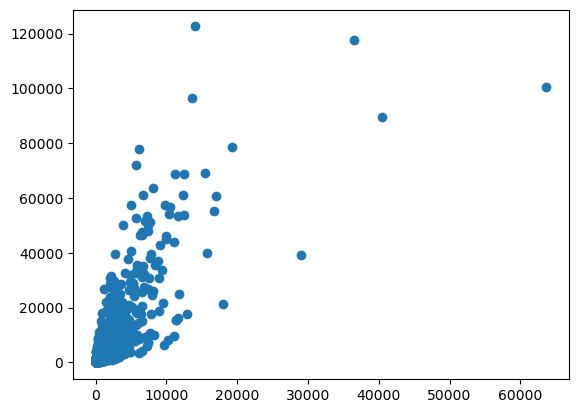

In [9]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(new_train_df['retweets_count'], new_train_df['favorites_count'])
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

In [10]:
train_df_input = new_train_df.drop(['retweets_count', 'text'], axis=1)
train_df_input

,favorites_count,followers_count,statuses_count,friends_count,urls,verified,hashtags
0,0,3682,453535,3628,0,0,0
1,0,86,1016,284,0,0,0
2,1,1944,28234,1995,0,0,0
3,0,1,1072,0,1,0,0
4,0,13957,25311,10841,0,0,0
...,...,...,...,...,...,...,...
353964,0,34,1509,55,1,0,0
353965,0,89,11166,127,0,0,0
353966,0,1888,712,3086,0,0,0
353967,0,139,486,320,0,0,0


In [11]:
cluster_cols = train_df_input[['favorites_count', 'followers_count', 'statuses_count', 'friends_count']].values
normalized = (cluster_cols - cluster_cols.mean(0)) / cluster_cols.std(0)

clustering = sklearn.cluster.BisectingKMeans()
clustering.fit(normalized)

BisectingKMeans()

In [12]:
print('  mean   |   std    |   min   |   max   |   len')
for i in range(clustering.n_clusters):
    print('%.2f' % new_train_df[clustering.labels_ == i]['retweets_count'].mean(),
          '    |    ',
          '%.2f' % new_train_df[clustering.labels_ == i]['retweets_count'].std(),
          '    |    ',
          '%.2f' % new_train_df[clustering.labels_ == i]['retweets_count'].min(),
          '    |    ',
          '%.2f' % new_train_df[clustering.labels_ == i]['retweets_count'].max(),
          '    |    ',
          new_train_df[clustering.labels_ == i]['retweets_count'].shape[0]
          )

  mean   |   std    |   min   |   max   |   len
11.43     |     129.20     |     0.00     |     11333.00     |     279945
16.87     |     117.13     |     0.00     |     5412.00     |     61957
99.88     |     353.65     |     0.00     |     4820.00     |     1721
16.85     |     184.03     |     0.00     |     5733.00     |     6845
2.31     |     10.59     |     0.00     |     208.00     |     2232
9119.09     |     8821.37     |     1261.00     |     63674.00     |     86
3208.08     |     3169.65     |     299.00     |     12889.00     |     39
137.02     |     420.39     |     0.00     |     7245.00     |     1144


In [13]:
train_df['urls'] = train_df['urls'].apply(ast.literal_eval)

In [14]:
url_set = set()

def add_to_set(set_obj):
    for obj in set_obj:
        url_set.add(obj)

train_df['urls'].apply(add_to_set)

0         None
1         None
2         None
3         None
4         None
          ... 
353964    None
353965    None
353966    None
353967    None
353968    None
Name: urls, Length: 353969, dtype: object

In [33]:
temp = train_df.explode('urls')[['urls', 'retweets_count']]
avg_per_url = temp.groupby(['urls']).mean().to_dict()['retweets_count']

In [34]:
def apply_avg_urls(list_obj):
    sum = 0
    for url in list_obj:
        sum += avg_per_url[url]
    return sum / len(list_obj) if len(list_obj) > 0 else 0.0

train_df['urls'].apply(apply_avg_urls)

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
353964    0.0
353965    0.0
353966    0.0
353967    0.0
353968    0.0
Name: urls, Length: 353969, dtype: float64

In [36]:
train_df['text'].apply(len)

0          34
1           9
2          19
3         123
4          26
         ... 
353964     30
353965     69
353966     29
353967     24
353968     45
Name: text, Length: 353969, dtype: int64

In [ ]:
plt.stem(new_train_df[new_train_df['retweets_count'] > 0]['retweets_count'])
plt.show()

In [ ]:
new_test_df = format_df(test_df, type='test', url_len_only=True, hashtag_len_only=True)
test_df_input = new_test_df.drop(['text'], axis=1)
test_df_input

In [ ]:
input_with_gts = pd.concat([train_df['retweets_count'], train_df_input], axis=1)

num_fts = input_with_gts.shape[1]
corr = np.corrcoef(input_with_gts.values.T)

fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(corr, cmap='bwr')
ax.set_xticks(np.arange(num_fts), labels=input_with_gts.columns)
ax.set_yticks(np.arange(num_fts), labels=input_with_gts.columns)
plt.colorbar(im)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(num_fts):
    for j in range(num_fts):
        text = ax.text(j, i, '%.2f' % corr[i, j], ha="center", va="center", color="k")
fig.tight_layout()
plt.show()

# NLP

In [ ]:
nlp_model = gensim.models.Word2Vec.load('models/word2vec.model')

train_tweets = new_train_df['text'].apply(str.split).to_list()
train_dictionary = gensim.corpora.Dictionary(train_tweets)
train_corpus = [train_dictionary.doc2bow(tweet) for tweet in train_tweets]

tfidf = gensim.models.TfidfModel(train_corpus)

In [ ]:
text = train_df['text'].iloc[3].split(' ')
text_vecs = nlp_model.wv[text]
text_img = text_vecs.T @ text_vecs


print(text)
plt.imshow(text_img)
plt.show()

In [ ]:
text = new_train_df['text']
i = 0
encoded_words = [word for word in text.iloc[i].split(' ') if word in nlp_model.wv and
                 word in train_dictionary.token2id]
if encoded_words:
    keys = [train_dictionary.token2id[word] for word in encoded_words]
    tf_idf_dict = dict(tfidf[train_corpus[i]])
    tf_idf_coefs = np.array([tf_idf_dict[key] for key in keys])

    text_vec = nlp_model.wv[encoded_words]
    text_vec = (text_vec * tf_idf_coefs[:, None]).sum(0)

text_vec

# Trees, Boosting

In [ ]:
full_train_X = train_df_input.values
full_train_X = (full_train_X - train_df_input.values.mean(0)) / train_df_input.values.std(0)

full_train_y = train_df['retweets_count'].values

full_test_X = (test_df_input.values - train_df_input.values.mean(0)) / train_df_input.values.std(0)

use_text = False

if use_text:
    train_text = train_df['text']
    test_text = test_df['text']

    new_train_X = np.zeros((full_train_X.shape[0], full_train_X.shape[1] + nlp_model.vector_size))
    new_test_X = np.zeros((full_train_X.shape[0], full_train_X.shape[1] + nlp_model.vector_size))

    for i in range(len(full_train_X)):
        text_vec = nlp_model.wv[train_text.iloc[i].split(' ')].mean(0)
        new_train_X[i] = np.concatenate([full_train_X[i], text_vec])

    for i in range(len(full_test_X)):
        encoded_words = [word for word in test_text.iloc[i].split(' ') if word in nlp_model.wv]
        if encoded_words:
            text_vec = nlp_model.wv[encoded_words].mean(0)
            new_test_X[i] = np.concatenate([full_test_X[i], text_vec])
        else:
            new_test_X[i] = np.concatenate([full_test_X[i], np.zeros((nlp_model.vector_size,))])

    full_train_X = new_train_X
    full_test_X = new_test_X

In [ ]:
perform_cv = False

if perform_cv:
    scores_xgboost = sklearn.model_selection.cross_validate(xgboost.XGBRegressor(verbosity=0,
                                                                                 max_depth=10),
                                                            full_train_X,
                                                            full_train_y,
                                                            cv=5,
                                                            scoring='neg_mean_absolute_error',
                                                            verbose=2)

    print(- scores_xgboost['test_score'].mean())

# Make submission

In [ ]:
make_submission = False

if make_submission:
    test_ids = test_df[['TweetID']]
    model = xgboost.XGBRegressor(verbosity=2)
    model.fit(full_train_X, full_train_y)

    test_predictions = model.predict(full_test_X)

    submission_df = pd.DataFrame(data={'retweets_count': test_predictions})
    submission_df = pd.concat([test_ids, submission_df], axis=1)
    submission_df.to_csv('data/submission.csv', index=False)